In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
f = '환율DATA.xlsx'
df = pd.read_excel(f, encoding='cp949', index_col=0, header=1)
df.shape

(248, 8)

In [3]:
df4 = df.iloc[:,:4]
df4 = df4.dropna() #NaN 하나라도 있으면 그 행을 버린다.

In [4]:
df4.head()

,보내실때,받으실때,사실때,파실때
2019.07.02,"1,178.10","1,155.50","1,187.21","1,146.39"
2019.07.01,"1,174.20","1,151.80","1,183.35","1,142.65"
2019.06.28,"1,166.70","1,144.30","1,175.72","1,135.28"
2019.06.27,"1,168.70","1,146.30","1,177.75","1,137.25"
2019.06.26,"1,168.70","1,146.30","1,177.75","1,137.25"


전처리 (문자 → 숫자) preprocessing

In [5]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2019.07.02 to 2018.06.29
Data columns (total 4 columns):
보내실때    248 non-null object
받으실때    248 non-null object
사실때     248 non-null object
파실때     248 non-null object
dtypes: object(4)
memory usage: 9.7+ KB


In [6]:
df4 = df4.replace(',','',regex=True)
df4 = df4.astype(np.float)

In [7]:
df4.head()

,보내실때,받으실때,사실때,파실때
2019.07.02,1178.1,1155.5,1187.21,1146.39
2019.07.01,1174.2,1151.8,1183.35,1142.65
2019.06.28,1166.7,1144.3,1175.72,1135.28
2019.06.27,1168.7,1146.3,1177.75,1137.25
2019.06.26,1168.7,1146.3,1177.75,1137.25


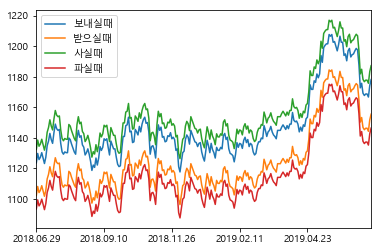

In [8]:
plt.rc('font', family='Malgun Gothic')
df4.iloc[::-1].plot()   # -1 : 거꾸로 소팅해서 보여주겠다. 

In [9]:
f2 = '8.8.1.1 주요국통화의 대원화 환.xls'
df2 = pd.read_excel(f2, encoding='cp949', index_col=0, header=3)
df2.shape

(369, 2)

In [10]:
df2.head()

,원자료,원자료.1
변환,,
2018/06/29,1121.7,1014.79
2018/06/30,NaN,NaN
2018/07/01,NaN,NaN
2018/07/02,1117.2,1009.26
2018/07/03,1117.4,1008.26


In [11]:
df2.columns = ['미국달러','일본엔']
df3 = df2.dropna()

In [12]:
df3.head()

,미국달러,일본엔
변환,,
2018/06/29,1121.7,1014.79
2018/07/02,1117.2,1009.26
2018/07/03,1117.4,1008.26
2018/07/04,1121.1,1014.34
2018/07/05,1115.3,1009.55


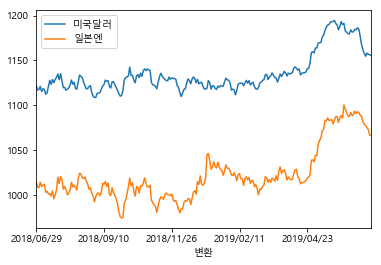

In [13]:
df3.plot()

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2018/06/29 to 2019/07/02
Data columns (total 2 columns):
미국달러    248 non-null float64
일본엔     248 non-null float64
dtypes: float64(2)
memory usage: 5.8+ KB


In [15]:
window_week = 4
window_day = window_week * 5  # 5일
predict_day = 5
window_day

20

X, Y 생성 갯수 체크
- 데이터가 30개 있으면? 20개로부터 5일 예측하므로 (20+5) = 1샘플, 총 5샘플
- 현재 데이터 248개 샘플, 총 223쌍 X,Y를 만들어야 합니다.
- X[224, 2 * 20], y[224, 2* 5]

In [34]:
before = df3.iloc[:-predict_day] #최근 데이터 5개 빼고
later = df3.iloc[window_day:] #과거 데이터 20개 빼고
df3.shape, before.shape, later.shape

((248, 2), (243, 2), (228, 2))

In [17]:
m = len(df3) - (predict_day + window_day - 1)
m

224

In [23]:
x_list = []
y_list = []
for i in range(m):
    x = df3.iloc[i:i+window_day]#20일간의 데이터
    y = df3.iloc[i+window_day:i+window_day+predict_day] #그다음 5일간의 데이터
    x_list.append(x.values)#날짜 인덱스 빼고 값만 저장
    y_list.append(y.values)

In [24]:
X = np.array(x_list)
y = np.array(y_list)
X.shape, y.shape #(m-instance, day, 특징수(달러,엔화))

((224, 20, 2), (224, 5, 2))

In [25]:
#2차원으로 변환
X = np.reshape(X, [m, -1])
y = np.reshape(y, [m, -1])
X.shape, y.shape # (달러,엔화,달러,엔화....)

((224, 40), (224, 10))

In [26]:
# train / test 분리
offset = 30 #테스트셋 
X_train = X[offset:]
X_test = X[:offset]
y_train = y[offset:]
y_test = y[:offset]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194, 40), (30, 40), (194, 10), (30, 10))

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr = Ridge(alpha=1.0).fit(X_train, y_train)

In [28]:
#성능 측정
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9205409191491469, -0.6542108232125314)

In [31]:
최근20일데이터 = df3.iloc[-window_day:]
최근20일데이터.shape

(20, 2)

In [32]:
#미래의 5일 환율 예측을 그래프로 시각화
최근20일데이터 = df3.iloc[-window_day:].values.reshape([1, -1])
미래의5일예측 = lr.predict(최근20일데이터)
미래의5일예측 = np.reshape(미래의5일예측, [predict_day, 2])#다시 3차원으로 변환
미래의5일예측.shape

(5, 2)

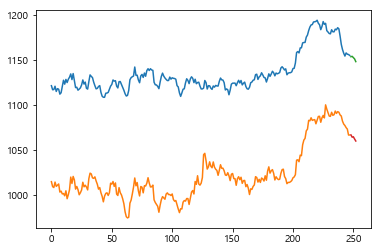

In [33]:
usa = df3.iloc[:,0].values
japan = df3.iloc[:,1].values
x_num = np.arange(len(usa))
x1_num = np.arange(len(usa),len(usa)+len(미래의5일예측))
plt.plot(x_num, usa)
plt.plot(x_num, japan)
plt.plot(x1_num, 미래의5일예측[:,0])
plt.plot(x1_num, 미래의5일예측[:,1])